## Chapter 6

### 결정 트리

* 분류, 회귀, 다중출력 작업이 가능한 머신러닝 알고리즘
* 매우 복잡한 데이터셋에도 사용가능.
* 자주 사용되는 알고리즘 중 하나인 Random Forest의 기본 구성 요소.

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import os

IMAGES_PATH=os.path.join(".","images","ch06")
os.makedirs(IMAGES_PATH, exist_ok=True)

os.environ["PATH"] += os.pathsep+"D:\Graphviz\bin"

In [5]:
# 붓꽃 데이터셋을 이용한 예측
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎의 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

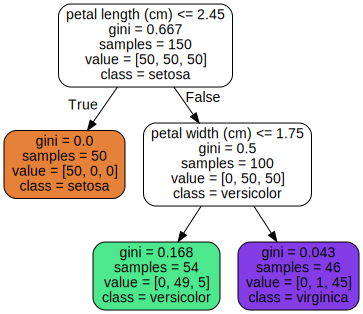

In [6]:
# decision tree 시각화
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    tree_clf,
    out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True,
)

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

> * root 노드에서, 꽃잎 길이(petal width)가 2.45보다 짧은지 검사하고, 참이면 왼쪽 자식 노드로 이동.(leaf node이므로 iris setosa로 결정)
> * 꽃잎 길이가 2.45보다 길면 오른쪽 자식 노드로 이동하고, 여기서는 다시 꽃잎 너비가 1.75보다 작으면 왼쪽 leaf 노드로, 그렇지 않으면 오른쪽 leaf node로 이동.
> * value['iris setosa', 'iris-versicolor', 'iris-virginica'] 순

* 결정 트리는 데이터 전처리가 거의 필요하지 않음.(특성 스케일링이 크게 필요없음.)
* 각 노드의 sample 속성은 얼마나 많은 훈련 샘플이 적용되었는지를 나타낸 것.
* 각 노드의 gini 속성은 불순도(impurity) 추정을 나타냄.
  * 한 노드의 모든 샘플이 같은 클래스에 있다면 이를 순수 노드라고 함(gini=0)
  * i번째 노드의 gini 점수 : $$ G_i=1-\sum_{k=1}^np_{i,k}^2 $$
    * $ p_{i,k} : i번째 노드에 있는 훈련 샘플 중 클래스 k에 속한 샘플의 비율
    * ex) 깊이 2의 왼쪽 노드의 gini 점수 : $ 1-(0/54)^2-(49/54)^2-(5/54)^2\approx 0.168 $
* scikitlearn은 이진 트리만 만드는 CART 알고리즘 사용.

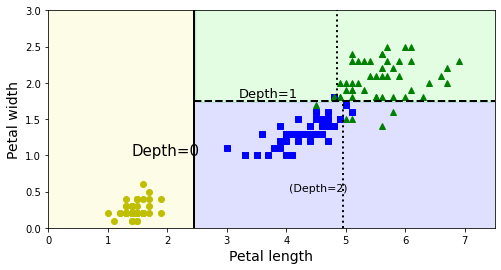

In [10]:
# 결정 트리의 결정 경계
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
plt.show()

> * 실선이 root node의 결정 경계. 왼쪽 부분은 순수 노드이므로 더이상 나누지 않고, 오른쪽은 순수 노드가 아니므로 긴 점선(깊이 1의 노드)으로 나눔.
> * max_depth가 2이기 때문에 더이상 나누지 않고, max_depth를 3으로 설정하면 가는 점선으로 깊이 2의 노드가 생성.

### 클래스 확률 추정

* 한 샘플이 클래스 k에 속할 확률을 추정할 수 있음.
* 해당 샘플에 속하는 노드를 찾은 뒤, 그 노드에 있는 클래스 k의 훈련 샘플의 비율을 반환.

In [11]:
# Iris-Versicolor의 확률이 제일 높음(90.7%)
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [12]:
tree_clf.predict([[5, 1.5]])

array([1])

### CART 알고리즘

* 결정 트리 훈련(트리의 성장)을 위해 사용하는 알고리즘.
* 훈련 세트를 하나의 특성 $ k $의 임곗값 $ t_k $를 사용해 두 개의 subset으로 나눔.
  * 가장 순수한 서브셋으로 나눌 수 있는 $ (k, t_k) $ 짝을 찾음.
  * CART 알고리즘은 다음 비용 함수의 값을 최소화하는 방식으로 tree를 나눔. : $$ J(k,t_k)=\frac{m_{left}}{m}G_{left}+\frac{m_{right}}{m}G_{right} $$
    * $ G_{left/right} $ : 왼쪽/오른쪽 subset의 불순도
    * $ m_{left/right} $ : 왼쪽/오른쪽 subset의 샘플 수 
* max_depth로 지정된 최대 깊이가 되거나 불순도를 줄이는 분할을 찾을 수 없을 때 중단.
* greedy algorithm 사용, 최적의 트리를 완벽히 찾는 것은 매우 힘듦

### 시간 복잡도

* 일반적으로 거의 균형을 이루므로 탐색에는 $ O(log(m)) $ 만큼 걸림.
* 예측에 필요한 전체 복잡도는 특성 수에 상관없이 역시 $ O(\log(m)) $ 이므로 훈련 세트가 커도 속도가 빠름.
* 훈련 시에는 모든 훈련 샘플의 모든 특성을 비교하므로 $ O(n\times m\log(m)) $
  * max_features 지정 시 지정한 수 이하로 비교
  * 샘플이 작을 경우 <code>presort=True</code> 지정 시 미리 데이터를 정렬하여 훈련 속도가 증가함.

### Entropy 불순도

* <code>criterion="entropy"</code>를 사용하여 엔트로피 불순도를 사용할 수 있음.
* 어떤 세트가 한 클래스의 샘플만 담고 있으면 엔트로피는 0
* i번째 엔트로피 계산 $$ H_i=-\sum_{k=1;P_{i,k\neq0}}^np_{i,k}\log(p_{i,k}) $$
* Gini 불순도와 Entropy 불순도는 큰 차이가 없지만, 지니 불순도가 계산이 조금 더 빠르고, 만약 두 방법이 서로 다른 트리를 만들게 되면 엔트로피 불순도 트리가 조금 더 균형잡힌 트리를 만듦.

### 규제 매개변수

* 결정 트리는 훈련 데이터에 대한 제약 사항이 거의 없으므로 제한을 두지 않으면 과대적합되기 쉬움.
* 훈련되기 전 파라미터 수가 결정되지 않는 비파라미터 모델(nonparametric model), 즉 모델 구조가 데이터에 맞춰 고정되지 않고 자유로움.
  * 선형 모델과 같은 파라미터 모델(parametric model)은 미리 정의된 모델 파라미ㄴ터 수를 가지므로 자유도가 제한되고 과대적합 위험이 줄어듬.
* 보통 트리의 최대 깊이(<code>max_depth</code>)를 줄여 규제함.
  * 기본값 : None(제한 없음)
* 그 외에 DecisionTreeClassifier는 제한을 위한 다른 매개변수가 존재
  * min_samples_split : 분할되기 위해 노드가 가져야 하는 최소 샘플 수
  * min_samples_leaf : leaf node가 가져야 할 최소 샘플 수
  * min_weight_fraction_leaf : min_samples_leaf와 유사. 가중치가 부여된 전체 샘플 수에서의 비율
  * max_leaf_nodes : leaf node의 최대 수
  * max_features : 각 노드에서 분할에 사용할 특성의 최대 수
* min_으로 시작하는 매개변수를 증가시키거나 max_로 시작하는 매개변수를 감소시키면 규제가 커짐

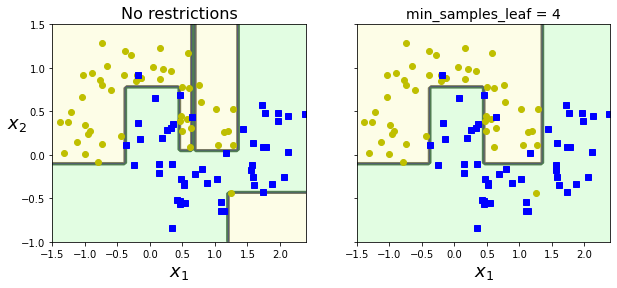

In [15]:
# moons 데이터셋을 결정 트리에 적용
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")
plt.show()

> * 왼쪽은 규제가 없어 괴대적합됨.
> * 오른쪽은 min_samples_leaf=4로 규제

* 제한 없이 트리를 훈련시키고 불필요한 트리를 제거(pruning)하는 방법도 있음. (<code>ccp_alpha</code> 를 이용해 사용가능)
  * 순도를 높이는 것이 큰 효과가 없다면 리프 노드 바로 위의 노드를 제거할 수 있음.
  * $ \chi^2 $ 검정 등을 사용해 우연히 향상된 것인지 추정하여, 해당 확률(p-값)이 임곗값보다 높으면 노드를 삭제. (https://ko.wikipedia.org/wiki/%EC%B9%B4%EC%9D%B4%EC%A0%9C%EA%B3%B1_%EA%B2%80%EC%A0%95)

## Regression

In [18]:
from sklearn.tree import DecisionTreeRegressor

m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

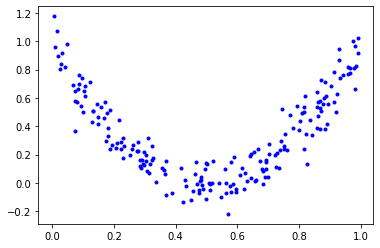

In [22]:
plt.plot(X, y, "b.")
plt.show()

In [29]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

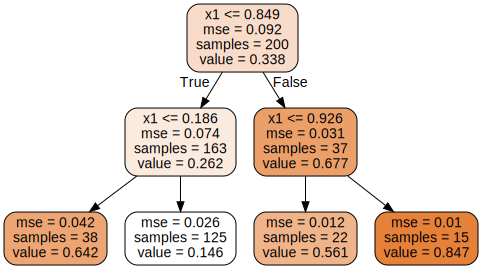

In [30]:
export_graphviz(
    tree_reg,
    out_file=os.path.join(IMAGES_PATH, "quadric_tree.dot"),
    feature_names=['x1'],
    rounded=True,
    filled=True,
)

Source.from_file(os.path.join(IMAGES_PATH, "quadric_tree.dot"))

> * 각 노드에서 클래스를 예측하는 대신 값을 예측함.
>   * ex) $ x_1=0.6 $의 타깃값을 예측한다면 노드 탐색 시 value=0.146인 노드에 도달.
>   * 각 leaf node의 훈련 샘플의 평균 타깃값이 예측값이 됨.
>   * 예측값들의 평균제곱오차를 <code>mse=</code>를 통해 표시

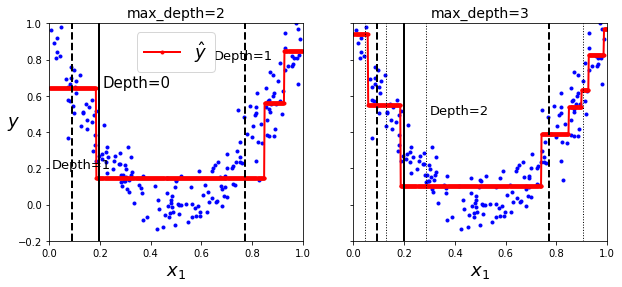

In [32]:
# tree_reg : max_depth=2
# tree_reg2 : max_depth=3
tree_reg2=DecisionTreeRegressor(max_depth=3)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)
plt.show()

* 불순도를 최소화하는 방향으로 분할하는 대신 평균제곱오차를 최소화하도록 분할.
* 알고리즘이 최소화하기 위한 비용 함수: $$ J(k, f_k)=\frac{m_{left}}{m}\text{MSE}_{left}+\frac{m_{right}}{m}\text{MSE}_{right} $$
  * $$ \text{MSE}_{node} = \frac{1}{m_{node}}\sum_{i\in node}(\hat{y}_{node}-y^{(i)})^2 $$
  * $$ \hat{y}_{node} = \frac{1}{m_{node}}\sum_{i\in node}y^{(i)} $$

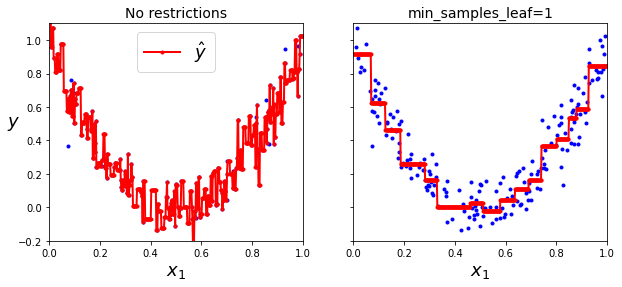

In [36]:
# 결정 트리를 이용한 회귀의 규제 여부 비교
# 오른쪽이 규제가 없고, 과대적합된 모습을 보임.
tree_reg_nores=DecisionTreeRegressor()
tree_reg_res=DecisionTreeRegressor(min_samples_leaf=10)

tree_reg_nores.fit(X, y)
tree_reg_res.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg_nores.predict(x1)
y_pred2 = tree_reg_res.predict(x1)
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)
plt.show()

### 결정 트리의 불안정성

* 결정 트리는 계단 모양의 결정 경계를 만드므로 훈련 세트의 회전에 민감함.
  * ex) 선형으로 구분되기 쉬운 데이터를 45도 회전시키면 결정경계가 구불구불해짐.
  * 해결을 위해 훈련 데이터를 더 좋은 방향으로 회전시키는 PCA기법 사용.
* 결정 트리는 훈련 데이터의 작은 변화에 민감함.
  * ex) 데이터를 하나만 추가하거나 제거해도 기존의 모델과 다른 모습의 결정 경계가 나옴.
* scikitlearn의 결정 트리 훈련 알고리즘은 확률적이므로(각 노드에서 평가할 후보 특성을 무작위로 선택) 같은 훈련 데이터에 대해서도 다른 모델을 얻을 수 있음.

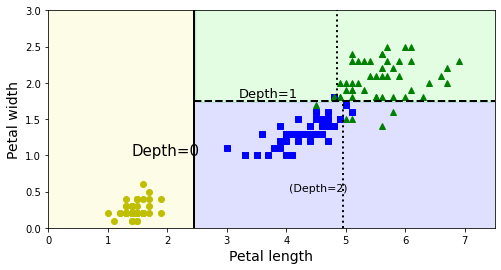

In [72]:
X = iris.data[:, 2:]
y = iris.target

X_removed = np.delete(X, np.where(X==[4.8, 1.8]), axis=0)
y_removed = np.delete(y, np.where(X==[4.8, 1.8]), axis=0)

tree_clf_original=DecisionTreeClassifier(random_state=42, max_depth=2)
tree_clf_removed=DecisionTreeClassifier(random_state=42, max_depth=2)

tree_clf_original.fit(X, y)
tree_clf_removed.fit(X_removed, y_removed)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_original, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
plt.show()

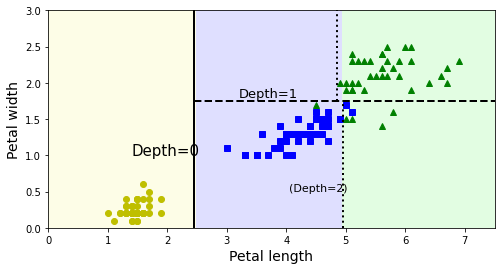

In [73]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_removed, X_removed, y_removed)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
plt.show()